In [1]:
# common stuff
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import warnings
warnings.simplefilter('ignore')
%pylab inline
%config InlineBackend.figure_format = 'png' 
from pylab import rcParams
rcParams['figure.figsize'] = 8,5
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_excel('geo_comment.xlsx')
print(df.shape)
display(df.head(10))
display(df.info())
# no NaNs, good

(70382, 5)


x          y  comment_class  multiplier  \
0  37.612416  55.777454             -1           1   
1  37.612416  55.777454             -1           1   
2  37.603298  55.742108             -1           1   
3  37.558526  55.728758             -1           1   
4  37.566431  55.731794             -1           1   
5  37.558526  55.728758             -1           1   
6  37.566431  55.731794             -1           1   
7  37.558957  55.723399             -1           1   
8  37.558957  55.723399             -1           1   
9  37.565767  55.734567             -1           1   

                                             comment  
0  Во все разделы правил землепользования и застр...  
1  На основании вступившего в законную силу судеб...  
2  Внести в Проект правил землепользования и заст...  
3  Учитывая социальную значимость проекта строите...  
4  Учитывая социальную значимость проекта строите...  
5  Установить зону развития по адресу: Новодевичи...  
6  Установить зону развития по адресу: Новодевичи...  
7  Прошу поменять зону сохранения нахождения объе...  
8  Прошу перевести из зоны сохранения в зону разв...  
9  Прошу внести технико-экономические показатели ...

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70382 entries, 0 to 70381
Data columns (total 5 columns):
x                70382 non-null float64
y                70382 non-null float64
comment_class    70382 non-null int64
multiplier       70382 non-null int64
comment          70382 non-null object
dtypes: float64(2), int64(2), object(1)
memory usage: 3.2+ MB


None

In [3]:
display(df["comment_class"].value_counts())
display(df["multiplier"].value_counts().sort(inplace=False, ascending=False).head(10))
# most are 1-person votes, mostly "against" votes

-1    58552
 1    11830
Name: comment_class, dtype: int64

1      69934
29        38
28        27
11        25
23        24
4         23
42        21
109       21
3         15
15        14
Name: multiplier, dtype: int64

In [4]:
# x,y are longitude and latitude, fix naming in order to avoid confusion
df["lon"] = df["x"]
df["lat"] = df["y"]
df.drop(["x", "y"], axis=1, inplace=True)
df.head()

comment_class  multiplier  \
0             -1           1   
1             -1           1   
2             -1           1   
3             -1           1   
4             -1           1   

                                             comment        lon        lat  
0  Во все разделы правил землепользования и застр...  37.612416  55.777454  
1  На основании вступившего в законную силу судеб...  37.612416  55.777454  
2  Внести в Проект правил землепользования и заст...  37.603298  55.742108  
3  Учитывая социальную значимость проекта строите...  37.558526  55.728758  
4  Учитывая социальную значимость проекта строите...  37.566431  55.731794

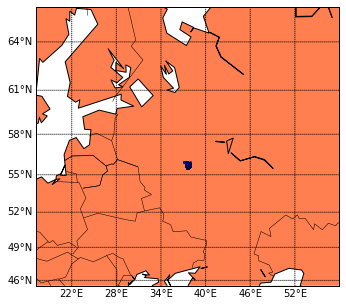

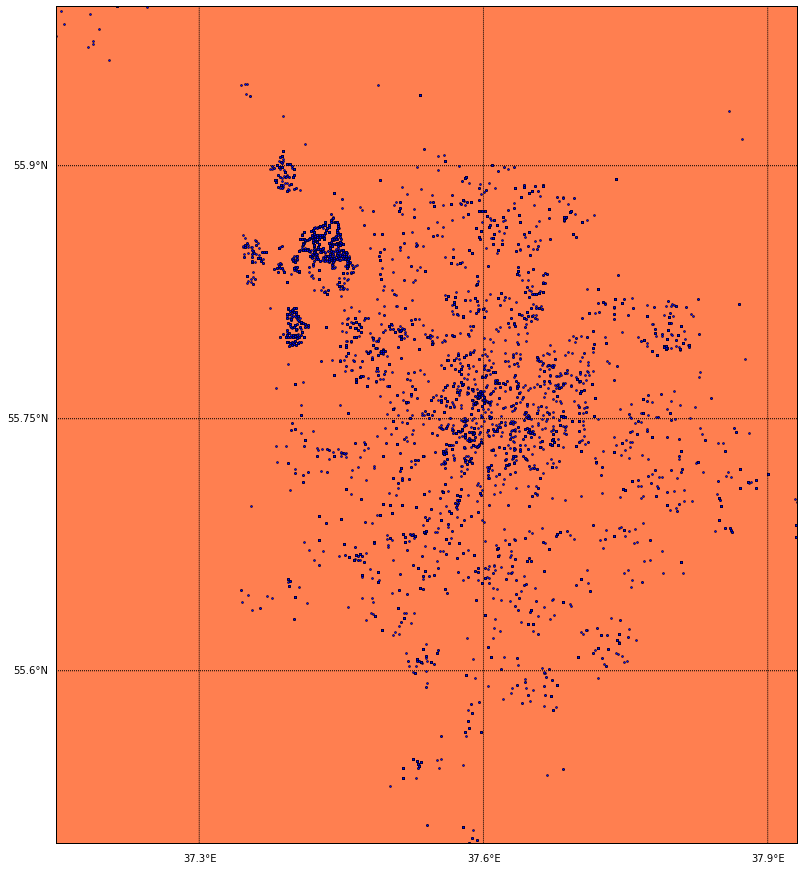

In [5]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import seaborn as sns

def draw_map(df, extra, grid_step):
    m = Basemap(
        projection='merc',
        llcrnrlon=df["lon"].min() - extra[1], llcrnrlat=df["lat"].min() - extra[0],
        urcrnrlon=df["lon"].max() + extra[1], urcrnrlat=df["lat"].max() + extra[0])    
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color = 'coral')
    m.drawmapboundary()
    m.drawparallels(np.arange(10.0, 70.0, grid_step), labels = [1,0,0,0])
    m.drawmeridians(np.arange(10.0, 70.0, grid_step*2), labels = [0,0,0,1])    
    x,y = m(df["lon"].ravel(), df["lat"].ravel())
    m.plot(x, y, 'bo', markersize=2)
    plt.show()
    
# let's draw it on a large-scale map
draw_map(df, (10, 20), 3)
# yepp, this does look like Moscow :)
# let's make a close-up
rcParams['figure.figsize'] = 15,15
draw_map(df, (0, 0), 0.15)
rcParams['figure.figsize'] = 8,5

In [6]:
#ok, better, but still... I want to see Moscow districts and stuff here. Let's do this!
import geotiler

mm = geotiler.Map(extent=(float(df["lon"].min()), float(df["lat"].min()),
    float(df["lon"].max()), float(df["lat"].max())), zoom=10)

moscow_img = geotiler.render_map(mm)

configuration file /home/stas/.config/geotiler/geotiler.ini does not exist


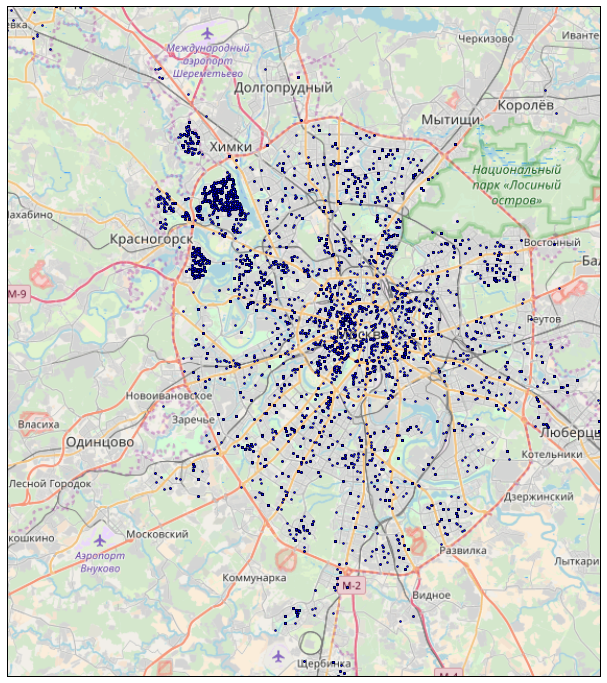

In [7]:
plt.figure(figsize=(12, 12))

m = Basemap(
    projection='merc',
    llcrnrlon=df["lon"].min(), llcrnrlat=df["lat"].min(),
    urcrnrlon=df["lon"].max(), urcrnrlat=df["lat"].max())

m.imshow(moscow_img, origin='upper')

x,y = m(df["lon"].ravel(), df["lat"].ravel())
m.plot(x, y, 'bo', markersize=2)

plt.show()
# Niiice, much better
# I can already see that there're ~5 clusters, i.e.: Golovinsky, Strogino, Kurkino, Mitino
# and Moscow center (though it's pretty messy), there're also a number of really small clusters
# like Vostochnoe Butovo, etc.

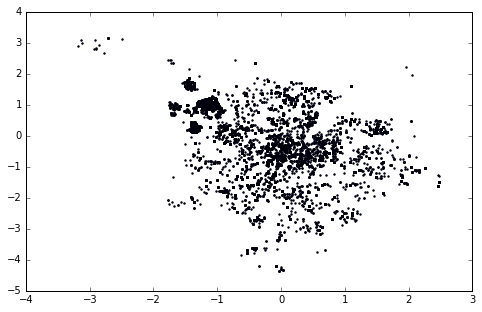

In [8]:
# Let's make a clustering
X = df[["lon", "lat"]]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Scaler stuff
X_scaled = scaler.fit_transform(X)

# Let's see how it looks like
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], s=2)
# Looks fine

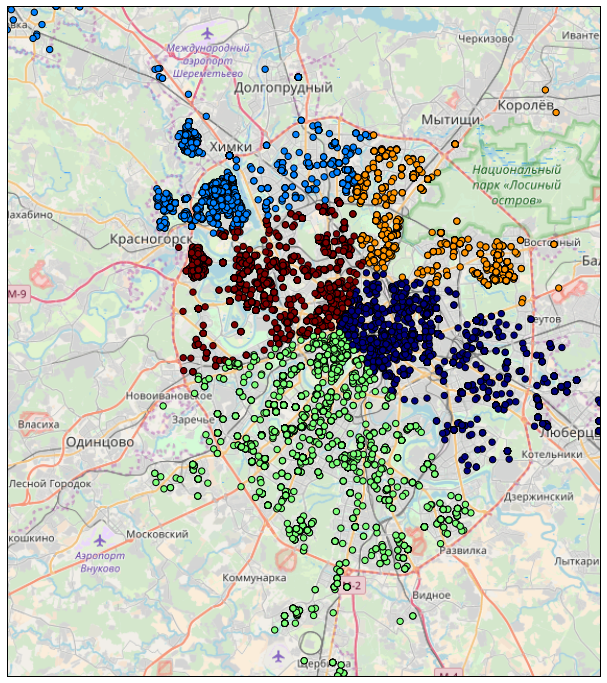

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def draw_clusters(df, Y, noise = False):
    plt.figure(figsize=(12, 12))
    m = Basemap(
        projection='merc',
        llcrnrlon=df["lon"].min(), llcrnrlat=df["lat"].min(),
        urcrnrlon=df["lon"].max(), urcrnrlat=df["lat"].max())
    m.imshow(moscow_img, origin='upper')
    x,y = m(df["lon"].ravel(), df["lat"].ravel())
    if noise:
        m.scatter(x[Y < 0], y[Y < 0], c=Y[Y < 0], s=40)        
    else:
        m.scatter(x[Y >= 0], y[Y >= 0], c=Y[Y >= 0], s=40)        
    plt.show()
    
# Let's just try k-means first with 5 clusters
# kmeans will use euclidean distance, for lat/lon it's
# better to use haversine distance, but let's just ignore that
# for now
    
clf = KMeans(n_clusters=5)
Y = clf.fit_predict(X_scaled)
draw_clusters(df, Y)

# Meh.
# Well, it's k-means

Num clusters = 18


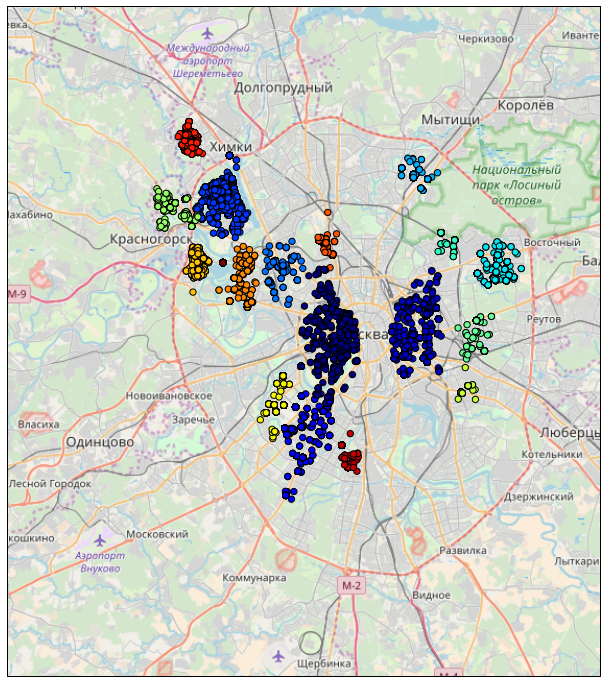

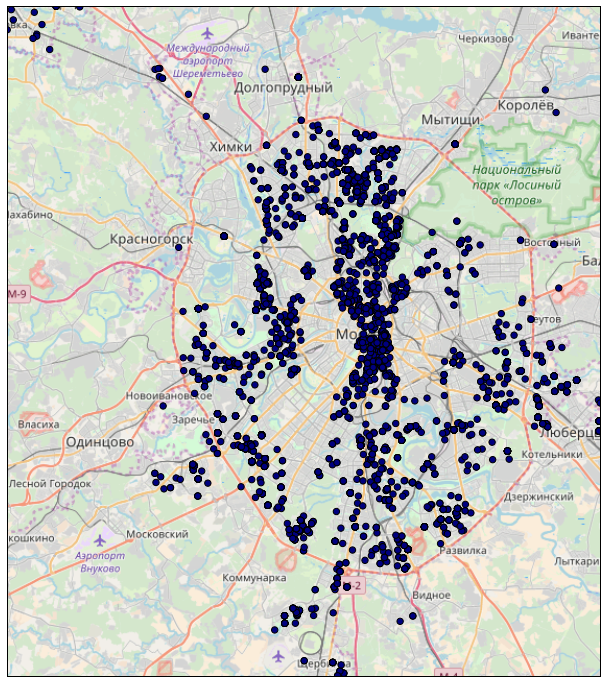

In [10]:
from sklearn.cluster import DBSCAN

# Let's try DBSCAN, DBSCAN allows us to use haversine, let's take advantage of that :)
# Since it's haversine on original data we can specify meaningful epsilon,
# let's take 1.5km, let's also take 500 as num samples, i.e. we specify
# that all votes within 1.5km range and with at least 500 neighbours are considered
# as one cluster

kms_per_radian = 6371.0088

clf = DBSCAN(eps=1.5 / kms_per_radian, min_samples=500, algorithm='ball_tree', metric='haversine')
Y = clf.fit_predict(np.radians(X))
print("Num clusters = %d" % len(set(Y[Y >= 0])))
# And plot clusters separately
draw_clusters(df, Y, False)
# From noise
draw_clusters(df, Y, True)
# Well, DBSCAN is definitely better than k-means, we can see
# Golovinsky, Strogino, Kurkino and Mitino clusters as well as many others
# which we didn't notice earlier because of the high density, now we can see
# that there're ~18 clusters

# As for the "noise", well, we may increase num_samples and eps and some of that
# will go to clusters, it all depends on the problem...

-1    58552
 1    11830
Name: comment_class, dtype: int64

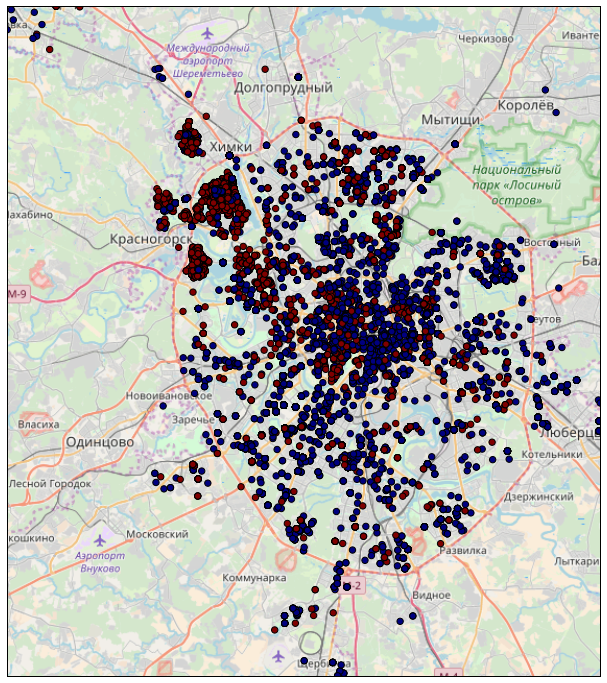

In [11]:
# Let's look at "yes" votes, we'll use DBSCAN from now on since k-means is pretty useless
# and DBSCAN looks like the right tool for geodata clustering (we could try other clustering algorithms,
# but seriously, DBSCAN hyperparams make sense and it's just what we need here)

# Let's look at total "yes" and "no" votes ("yes" votes are red)
display(df["comment_class"].value_counts())
Y = np.ones(len(df))
Y[(df["comment_class"] == -1).ravel()] = 0
draw_clusters(df, Y)
# So, looks like Moscow center is mostly "no" votes and they're majority,
# more distant districts are mostly "yes" votes and they're minority

Yes clusters = 4


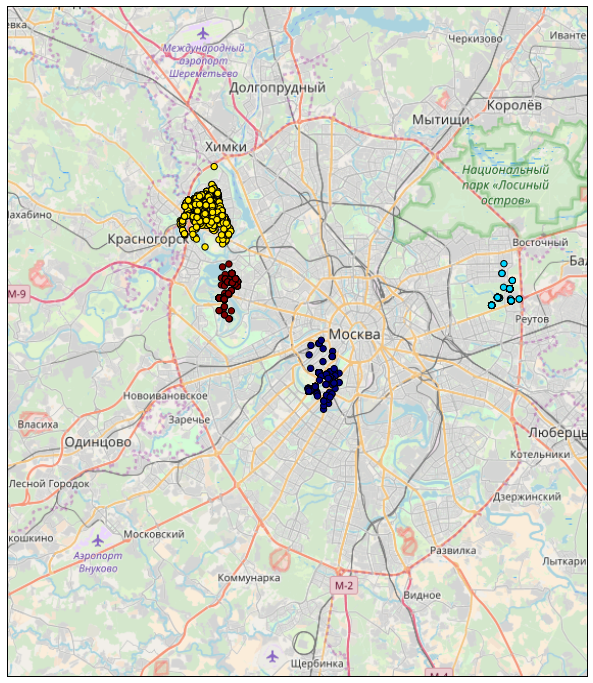

No clusters = 17


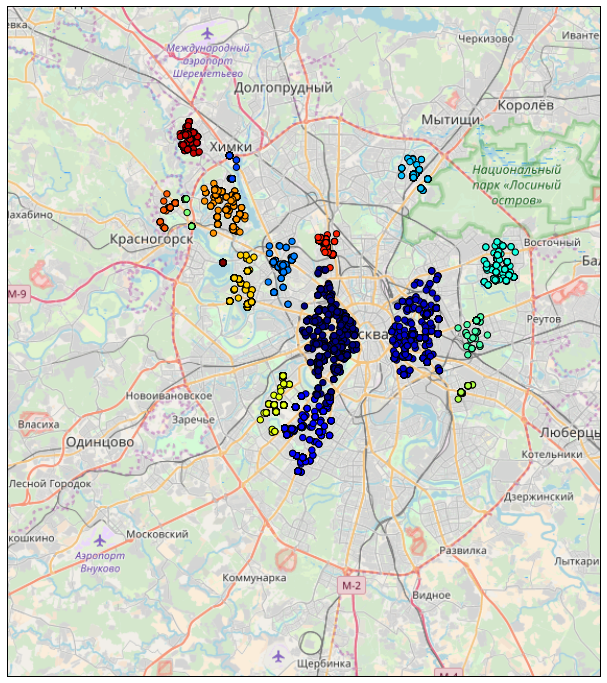

In [12]:
# Clusters

Xyes = X[df["comment_class"] == 1]
Xno = X[df["comment_class"] == -1]

clf = DBSCAN(eps=1.5 / kms_per_radian, min_samples=500, algorithm='ball_tree', metric='haversine')
Y = clf.fit_predict(np.radians(Xyes))
print("Yes clusters = %d" % len(set(Y[Y >= 0])))
draw_clusters(Xyes, Y, False)

clf = DBSCAN(eps=1.5 / kms_per_radian, min_samples=500, algorithm='ball_tree', metric='haversine')
Y = clf.fit_predict(np.radians(Xno))
print("No clusters = %d" % len(set(Y[Y >= 0])))
draw_clusters(Xno, Y, False)